# Packages

In [1]:
!pip install torchmetrics tqdm --upgrade

# Imports

In [14]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader, random_split

from torchmetrics.text import Perplexity

import tqdm

from collections import Counter
from torchview import draw_graph

# Configuration

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
seq_len = 25
batch_size = 25
min_freq = 0

num_epochs = 100

max_lr_dec = 3
lr_dec = 0


# Utils

In [3]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [4]:
def num_trainable_params(model):
  nums = sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6
  return nums

# Dataset

## Download Dataset

In [ ]:
!wget --quiet --continue https://s3.amazonaws.com/research.metamind.io/wikitext/wikitext-2-v1.zip
!unzip -q wikitext-2-v1.zip
!cd wikitext-2 && mv wiki.train.tokens train.txt
!cd wikitext-2 && mv wiki.valid.tokens valid.txt
!cd wikitext-2 && mv wiki.test.tokens test.txt

In [6]:
char2ind = {}
def data_init():
    global char2ind
    with open("./wikitext-2/train.txt", encoding="utf8") as f:
        file = f.read()
        trn = file[1:].split(' ')
    with open("./wikitext-2/valid.txt", encoding="utf8") as f:
        file = f.read()
        vld = file[1:].split(' ')
    with open("./wikitext-2/test.txt", encoding="utf8") as f:
        file = f.read()
        tst = file[1:].split(' ')
    words = sorted(set(trn))
    char2ind = {c: i for i, c in enumerate(words)}
    trn = [char2ind[c] for c in trn]
    vld = [char2ind[c] for c in vld]
    tst = [char2ind[c] for c in tst]
    return torch.tensor(trn,dtype=torch.int64), torch.tensor(vld,dtype=torch.int64), torch.tensor(tst,dtype=torch.int64), len(words)

def findWordByToken(iToken):
    for word, toekn in char2ind.items():  # for name, age in dictionary.iteritems():  (for Python 2.x)
        if toekn == iToken:
            return word
    return ''

In [7]:
class Wikitext2Dataset(Dataset):
  def __init__(self, tokens, seq_len):
    self.tokens = tokens
    self.seq_len = seq_len
  def __len__(self):
    return  len(self.tokens) // self.seq_len

  def __getitem__(self, idx):
    start_idx = idx * self.seq_len
    end_idx = start_idx + self.seq_len
    input = self.tokens[start_idx:end_idx]
    target = self.tokens[start_idx+1:end_idx+1]
    return torch.tensor(input), torch.tensor(target)

In [8]:
train_tokens_voc , valid_tokens_voc , test_tokens_voc , vocab_size= data_init()

# Datasets
train_dataset = Wikitext2Dataset(train_tokens_voc, seq_len)
valid_dataset = Wikitext2Dataset(valid_tokens_voc, seq_len)
test_dataset = Wikitext2Dataset(test_tokens_voc, seq_len)

# Dataloaders
train_loader = DataLoader(train_dataset , batch_size )
valid_loader = DataLoader(valid_dataset , batch_size )
test_loader = DataLoader(test_dataset , batch_size )

# Model

In [9]:
class H_LSTM(nn.Module):

  def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, dropout_rate):
    super().__init__()
    self.vocab_size = vocab_size
    
    #Embedding Layer
    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    self.dropout_em = nn.Dropout(0.1)
    
    # Layer 1
    self.rnn1 = nn.LSTM(input_size=embedding_dim,
                      hidden_size=hidden_dim,
                      num_layers=num_layers,
                      bidirectional=False,
                      batch_first=True)
    self.dropout1 = nn.Dropout(dropout_rate)
    
    # Layer 2
    self.rnn2 = nn.LSTM(input_size=hidden_dim,
                      hidden_size=hidden_dim,
                      num_layers=num_layers,
                      bidirectional=False,
                      batch_first=True)
    self.dropout2 = nn.Dropout(dropout_rate)
    
    # Layer 3
    self.rnn3 = nn.LSTM(input_size=hidden_dim,
                      hidden_size=hidden_dim,
                      num_layers=1,
                      bidirectional=False,
                      batch_first=True)
    self.dropout3 = nn.Dropout(dropout_rate)
    
    self.fc = nn.Linear(hidden_dim,vocab_size,bias=True)

  def forward(self, src):
    embedding = self.dropout_em( self.embedding(src) )
    
    output, (h,c) = self.rnn1(embedding)
    output = self.dropout1(output)
    
    output, (h,c) = self.rnn2(output,(c,h))
    output = self.dropout2(output)
    
    output, (h,c) = self.rnn3(output,(c,h))
    output = self.dropout3(output)
    
    output = self.fc(output)
    return output

# Train

## Learning Functions

In [10]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, perp , epoch=1):
  
  global seq_len
  global batch_size
  
  model.train()
  loss_train = AverageMeter()
  perplexity_train = AverageMeter()
    
  with tqdm.tqdm(train_loader, unit='batch') as tepoch:
    for inputs, targets in tepoch:

      tepoch.set_description(f'Epoch {epoch}')

      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)

      batch_size, seq_len, vocab_size = outputs.size()
      outputs = outputs.view(batch_size * seq_len, vocab_size)
      targets = targets.view(-1)
      
      loss = loss_fn(outputs, targets)
      
      loss.backward()
      
      perplexity = perp(outputs.view(batch_size, seq_len, vocab_size), targets.view(batch_size, seq_len))
      
      optimizer.step()
      optimizer.zero_grad()

      loss_train.update(loss.item(), n=len(targets))
      perplexity_train.update(perplexity.item(), n=len(targets))

      tepoch.set_postfix(loss=loss_train.avg, perplexity = perplexity_train.avg )
      
      del inputs
      del targets
      del outputs

  return model, loss_train.avg, perplexity_train.avg 

In [11]:
def evaluate(model, test_loader, loss_fn , perp ):
  
  global seq_len
  global batch_size
  
  model.eval()
  loss_eval = AverageMeter()
  perplexity_eval = AverageMeter()

  with torch.inference_mode():
    for inputs, targets in test_loader:
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)
      
      batch_size, seq_len, vocab_size = outputs.size()
      outputs = outputs.view(batch_size * seq_len, vocab_size)
      targets = targets.view(-1)

      loss = loss_fn(outputs, targets)
      
      perplexity = perp(outputs.view(batch_size, seq_len, vocab_size), targets.view(batch_size, seq_len))

      loss_eval.update(loss.item(), n=len(targets))
      perplexity_eval.update(perplexity.item(), n=len(targets))
      
      del inputs
      del targets
      del outputs

  return loss_eval.avg,perplexity_eval.avg

## Parameters

In [12]:
embedding_dim = 500
hidden_dim = 500
num_layers = 1
dropout_rate = 0.25


model = H_LSTM( vocab_size, embedding_dim=embedding_dim, hidden_dim=hidden_dim , num_layers=num_layers, dropout_rate= dropout_rate )
model = model.to(device)

loss_train_hist = []
loss_valid_hist = []

per_train_hist = []
per_valid_hist = []

lr_train_hist = []

best_perplexity_valid = torch.inf
epoch_counter = 0

model

H_LSTM(
  (embedding): Embedding(33278, 500)
  (dropout_em): Dropout(p=0.1, inplace=False)
  (rnn1): LSTM(500, 500, batch_first=True)
  (dropout1): Dropout(p=0.25, inplace=False)
  (rnn2): LSTM(500, 500, batch_first=True)
  (dropout2): Dropout(p=0.25, inplace=False)
  (rnn3): LSTM(500, 500, batch_first=True)
  (dropout3): Dropout(p=0.25, inplace=False)
  (fc): Linear(in_features=500, out_features=33278, bias=True)
)

In [13]:
num_trainable_params(model)

39.323278

/tmp/ipykernel_57918/1059837893.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(input), torch.tensor(target)


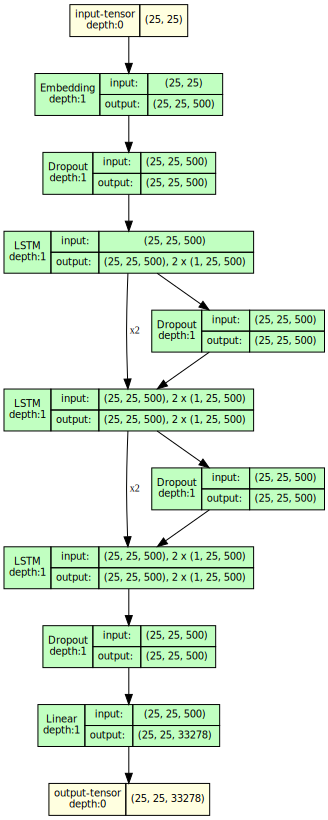

In [16]:
inputs, targets = next(iter(train_loader))
model_graph = draw_graph(model, input_data=inputs ,expand_nested=True,save_graph=True)
model_graph.visual_graph

## Learning Loop

In [19]:

lr = 0.5
wd = 1e-5
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9)
loss_fn = nn.CrossEntropyLoss()  
perp = Perplexity().to(device)

In [20]:
num_epochs = 300
max_lr_dec = 5
lr_dec = 0

for epoch in range(num_epochs):
  # Train
  model, loss_train, per_train = train_one_epoch(model, train_loader, loss_fn, optimizer, perp , epoch)
  # Validation
  loss_valid, per_val = evaluate(model, valid_loader, loss_fn, perp)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  per_train_hist.append(per_train)
  per_valid_hist.append(per_val)

  lr_train_hist.append(lr)
  
  print(f'Valid: Loss = {loss_valid:.4} Perplexity= {per_val:.4}, LR = {lr}')
  epoch_counter += 1
  
  if per_val < best_perplexity_valid:
    lr_dec = 0
    torch.save(model, f'model.pt')
    best_perplexity_valid = per_val
    print('Model Saved!')
  else:
    if lr_dec >= max_lr_dec :
      print("LR_DEC==3 , Finished")
      break
    lr_dec += 1
    
    del model
    del perp
    del loss_fn
    del optimizer
    
    model_path = 'model.pt'
    model = torch.load(model_path,map_location=device)
    lr /= 2
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9)
    loss_fn = nn.CrossEntropyLoss()
    perp = Perplexity().to(device)
  print()
  

  0%|          | 0/3342 [00:00<?, ?batch/s]/tmp/ipykernel_16013/1059837893.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(input), torch.tensor(target)
Epoch 0: 100%|██████████| 3342/3342 [01:16<00:00, 43.95batch/s, loss=6.38, perplexity=759]    


Valid: Loss = 5.762 Perplexity= 329.7, LR = 0.5
Model Saved!



Epoch 1: 100%|██████████| 3342/3342 [01:14<00:00, 44.75batch/s, loss=5.67, perplexity=306]


Valid: Loss = 5.233 Perplexity= 194.8, LR = 0.5
Model Saved!



Epoch 2: 100%|██████████| 3342/3342 [01:08<00:00, 48.96batch/s, loss=5.07, perplexity=168]


Valid: Loss = 4.611 Perplexity= 104.5, LR = 0.5
Model Saved!



Epoch 3: 100%|██████████| 3342/3342 [01:09<00:00, 48.28batch/s, loss=4.51, perplexity=95.8]


Valid: Loss = 4.147 Perplexity= 65.62, LR = 0.5
Model Saved!



Epoch 4: 100%|██████████| 3342/3342 [01:08<00:00, 48.97batch/s, loss=4.1, perplexity=63.4] 


Valid: Loss = 3.806 Perplexity= 46.71, LR = 0.5
Model Saved!



Epoch 5: 100%|██████████| 3342/3342 [01:08<00:00, 48.56batch/s, loss=3.78, perplexity=45.8]


Valid: Loss = 3.533 Perplexity= 35.53, LR = 0.5
Model Saved!



Epoch 6: 100%|██████████| 3342/3342 [01:08<00:00, 48.87batch/s, loss=3.5, perplexity=34.5] 


Valid: Loss = 3.274 Perplexity= 27.47, LR = 0.5
Model Saved!



Epoch 7: 100%|██████████| 3342/3342 [01:09<00:00, 48.12batch/s, loss=3.26, perplexity=27]  


Valid: Loss = 3.085 Perplexity= 22.72, LR = 0.5
Model Saved!



Epoch 8: 100%|██████████| 3342/3342 [01:09<00:00, 48.28batch/s, loss=3.04, perplexity=21.8]


Valid: Loss = 2.891 Perplexity= 18.71, LR = 0.5
Model Saved!



Epoch 9: 100%|██████████| 3342/3342 [01:09<00:00, 47.85batch/s, loss=2.85, perplexity=18]  


Valid: Loss = 2.728 Perplexity= 15.9, LR = 0.5
Model Saved!



Epoch 10: 100%|██████████| 3342/3342 [01:09<00:00, 48.23batch/s, loss=2.75, perplexity=16.5]


Valid: Loss = 2.636 Perplexity= 14.49, LR = 0.5
Model Saved!



Epoch 11: 100%|██████████| 3342/3342 [01:08<00:00, 48.63batch/s, loss=2.55, perplexity=13.2]


Valid: Loss = 2.492 Perplexity= 12.53, LR = 0.5
Model Saved!



Epoch 12: 100%|██████████| 3342/3342 [01:09<00:00, 47.90batch/s, loss=2.4, perplexity=11.5] 


Valid: Loss = 2.337 Perplexity= 10.71, LR = 0.5
Model Saved!



Epoch 13: 100%|██████████| 3342/3342 [01:10<00:00, 47.70batch/s, loss=2.28, perplexity=10.1]


Valid: Loss = 2.268 Perplexity= 10.02, LR = 0.5
Model Saved!



Epoch 14: 100%|██████████| 3342/3342 [01:10<00:00, 47.72batch/s, loss=2.19, perplexity=9.17]


Valid: Loss = 2.173 Perplexity= 9.092, LR = 0.5
Model Saved!



Epoch 15: 100%|██████████| 3342/3342 [01:09<00:00, 47.79batch/s, loss=2.1, perplexity=8.37] 


Valid: Loss = 2.106 Perplexity= 8.49, LR = 0.5
Model Saved!



Epoch 16: 100%|██████████| 3342/3342 [01:09<00:00, 48.29batch/s, loss=2.02, perplexity=7.71]


Valid: Loss = 2.061 Perplexity= 8.117, LR = 0.5
Model Saved!



Epoch 17: 100%|██████████| 3342/3342 [01:09<00:00, 48.02batch/s, loss=1.94, perplexity=7.18]


Valid: Loss = 1.986 Perplexity= 7.53, LR = 0.5
Model Saved!



Epoch 18: 100%|██████████| 3342/3342 [01:09<00:00, 48.14batch/s, loss=1.88, perplexity=6.71]


Valid: Loss = 1.937 Perplexity= 7.167, LR = 0.5
Model Saved!



Epoch 19: 100%|██████████| 3342/3342 [01:08<00:00, 48.52batch/s, loss=1.82, perplexity=6.33]


Valid: Loss = 1.897 Perplexity= 6.882, LR = 0.5
Model Saved!



Epoch 20: 100%|██████████| 3342/3342 [01:09<00:00, 48.02batch/s, loss=1.77, perplexity=5.98]


Valid: Loss = 1.828 Perplexity= 6.416, LR = 0.5
Model Saved!



Epoch 21: 100%|██████████| 3342/3342 [01:09<00:00, 47.81batch/s, loss=1.72, perplexity=5.73]


Valid: Loss = 1.822 Perplexity= 6.37, LR = 0.5
Model Saved!



Epoch 22: 100%|██████████| 3342/3342 [01:09<00:00, 48.00batch/s, loss=1.67, perplexity=5.45]


Valid: Loss = 1.77 Perplexity= 6.049, LR = 0.5
Model Saved!



Epoch 23: 100%|██████████| 3342/3342 [01:09<00:00, 48.19batch/s, loss=1.63, perplexity=5.22]


Valid: Loss = 1.718 Perplexity= 5.743, LR = 0.5
Model Saved!



Epoch 24: 100%|██████████| 3342/3342 [01:10<00:00, 47.52batch/s, loss=1.59, perplexity=5.01]


Valid: Loss = 1.687 Perplexity= 5.564, LR = 0.5
Model Saved!



Epoch 25: 100%|██████████| 3342/3342 [01:09<00:00, 48.12batch/s, loss=1.56, perplexity=4.85]


Valid: Loss = 1.661 Perplexity= 5.416, LR = 0.5
Model Saved!



Epoch 26: 100%|██████████| 3342/3342 [01:10<00:00, 47.63batch/s, loss=1.53, perplexity=4.7] 


Valid: Loss = 1.662 Perplexity= 5.419, LR = 0.5



Epoch 27: 100%|██████████| 3342/3342 [01:09<00:00, 48.16batch/s, loss=1.17, perplexity=3.28]


Valid: Loss = 1.26 Perplexity= 3.611, LR = 0.25
Model Saved!



Epoch 28: 100%|██████████| 3342/3342 [01:09<00:00, 48.13batch/s, loss=1.06, perplexity=2.94]


Valid: Loss = 1.229 Perplexity= 3.495, LR = 0.25
Model Saved!



Epoch 29: 100%|██████████| 3342/3342 [01:09<00:00, 48.13batch/s, loss=1.02, perplexity=2.81]


Valid: Loss = 1.193 Perplexity= 3.37, LR = 0.25
Model Saved!



Epoch 30: 100%|██████████| 3342/3342 [01:08<00:00, 48.49batch/s, loss=0.996, perplexity=2.74]


Valid: Loss = 1.196 Perplexity= 3.38, LR = 0.25



Epoch 31: 100%|██████████| 3342/3342 [01:08<00:00, 48.47batch/s, loss=0.846, perplexity=2.35]


Valid: Loss = 1.016 Perplexity= 2.816, LR = 0.125
Model Saved!



Epoch 32: 100%|██████████| 3342/3342 [01:09<00:00, 48.31batch/s, loss=0.795, perplexity=2.23]


Valid: Loss = 0.9928 Perplexity= 2.749, LR = 0.125
Model Saved!



Epoch 33: 100%|██████████| 3342/3342 [01:10<00:00, 47.71batch/s, loss=0.773, perplexity=2.18]


Valid: Loss = 0.9799 Perplexity= 2.71, LR = 0.125
Model Saved!



Epoch 34: 100%|██████████| 3342/3342 [01:09<00:00, 47.89batch/s, loss=0.76, perplexity=2.15] 


Valid: Loss = 0.9682 Perplexity= 2.679, LR = 0.125
Model Saved!



Epoch 35: 100%|██████████| 3342/3342 [01:09<00:00, 47.99batch/s, loss=0.749, perplexity=2.13]


Valid: Loss = 0.9642 Perplexity= 2.668, LR = 0.125
Model Saved!



Epoch 36: 100%|██████████| 3342/3342 [01:09<00:00, 47.89batch/s, loss=0.74, perplexity=2.11] 


Valid: Loss = 0.9563 Perplexity= 2.646, LR = 0.125
Model Saved!



Epoch 37: 100%|██████████| 3342/3342 [01:08<00:00, 48.61batch/s, loss=0.732, perplexity=2.09]


Valid: Loss = 0.9561 Perplexity= 2.645, LR = 0.125
Model Saved!



Epoch 38: 100%|██████████| 3342/3342 [01:08<00:00, 48.54batch/s, loss=0.725, perplexity=2.08]


Valid: Loss = 0.9473 Perplexity= 2.621, LR = 0.125
Model Saved!



Epoch 39: 100%|██████████| 3342/3342 [01:09<00:00, 48.42batch/s, loss=0.72, perplexity=2.07] 


Valid: Loss = 0.9442 Perplexity= 2.613, LR = 0.125
Model Saved!



Epoch 40: 100%|██████████| 3342/3342 [01:09<00:00, 47.79batch/s, loss=0.716, perplexity=2.06]


Valid: Loss = 0.9465 Perplexity= 2.619, LR = 0.125



Epoch 41: 100%|██████████| 3342/3342 [01:09<00:00, 47.90batch/s, loss=0.632, perplexity=1.89]


Valid: Loss = 0.8542 Perplexity= 2.383, LR = 0.0625
Model Saved!



Epoch 42: 100%|██████████| 3342/3342 [01:09<00:00, 48.38batch/s, loss=0.611, perplexity=1.85]


Valid: Loss = 0.8466 Perplexity= 2.365, LR = 0.0625
Model Saved!



Epoch 43: 100%|██████████| 3342/3342 [01:07<00:00, 49.16batch/s, loss=0.602, perplexity=1.83]


Valid: Loss = 0.8341 Perplexity= 2.335, LR = 0.0625
Model Saved!



Epoch 44: 100%|██████████| 3342/3342 [01:10<00:00, 47.62batch/s, loss=0.596, perplexity=1.82]


Valid: Loss = 0.8329 Perplexity= 2.332, LR = 0.0625
Model Saved!



Epoch 45: 100%|██████████| 3342/3342 [01:11<00:00, 46.61batch/s, loss=0.593, perplexity=1.82]


Valid: Loss = 0.831 Perplexity= 2.327, LR = 0.0625
Model Saved!



Epoch 46: 100%|██████████| 3342/3342 [01:16<00:00, 43.63batch/s, loss=0.588, perplexity=1.81]


Valid: Loss = 0.829 Perplexity= 2.322, LR = 0.0625
Model Saved!



Epoch 47: 100%|██████████| 3342/3342 [01:16<00:00, 43.51batch/s, loss=0.584, perplexity=1.8] 


Valid: Loss = 0.8257 Perplexity= 2.314, LR = 0.0625
Model Saved!



Epoch 48: 100%|██████████| 3342/3342 [01:17<00:00, 43.25batch/s, loss=0.581, perplexity=1.79]


Valid: Loss = 0.8249 Perplexity= 2.312, LR = 0.0625
Model Saved!



Epoch 49: 100%|██████████| 3342/3342 [01:09<00:00, 48.15batch/s, loss=0.578, perplexity=1.79]


Valid: Loss = 0.8234 Perplexity= 2.309, LR = 0.0625
Model Saved!



Epoch 50: 100%|██████████| 3342/3342 [01:09<00:00, 47.91batch/s, loss=0.574, perplexity=1.78]


Valid: Loss = 0.822 Perplexity= 2.305, LR = 0.0625
Model Saved!



Epoch 51: 100%|██████████| 3342/3342 [01:09<00:00, 48.17batch/s, loss=0.572, perplexity=1.78]


Valid: Loss = 0.8188 Perplexity= 2.297, LR = 0.0625
Model Saved!



Epoch 52: 100%|██████████| 3342/3342 [01:10<00:00, 47.51batch/s, loss=0.569, perplexity=1.77]


Valid: Loss = 0.8127 Perplexity= 2.284, LR = 0.0625
Model Saved!



Epoch 53: 100%|██████████| 3342/3342 [01:09<00:00, 48.02batch/s, loss=0.565, perplexity=1.77]


Valid: Loss = 0.8134 Perplexity= 2.284, LR = 0.0625



Epoch 54: 100%|██████████| 3342/3342 [01:09<00:00, 47.83batch/s, loss=0.526, perplexity=1.7] 


Valid: Loss = 0.7646 Perplexity= 2.174, LR = 0.03125
Model Saved!



Epoch 55: 100%|██████████| 3342/3342 [01:09<00:00, 48.00batch/s, loss=0.516, perplexity=1.68]


Valid: Loss = 0.7597 Perplexity= 2.163, LR = 0.03125
Model Saved!



Epoch 56: 100%|██████████| 3342/3342 [01:09<00:00, 48.11batch/s, loss=0.511, perplexity=1.67]


Valid: Loss = 0.7576 Perplexity= 2.158, LR = 0.03125
Model Saved!



Epoch 57: 100%|██████████| 3342/3342 [01:10<00:00, 47.13batch/s, loss=0.508, perplexity=1.67]


Valid: Loss = 0.7566 Perplexity= 2.156, LR = 0.03125
Model Saved!



Epoch 58: 100%|██████████| 3342/3342 [01:10<00:00, 47.40batch/s, loss=0.505, perplexity=1.66]


Valid: Loss = 0.7553 Perplexity= 2.153, LR = 0.03125
Model Saved!



Epoch 59: 100%|██████████| 3342/3342 [01:10<00:00, 47.58batch/s, loss=0.503, perplexity=1.66]


Valid: Loss = 0.7517 Perplexity= 2.145, LR = 0.03125
Model Saved!



Epoch 60: 100%|██████████| 3342/3342 [01:10<00:00, 47.46batch/s, loss=0.5, perplexity=1.65]  


Valid: Loss = 0.7489 Perplexity= 2.139, LR = 0.03125
Model Saved!



Epoch 61: 100%|██████████| 3342/3342 [01:10<00:00, 47.74batch/s, loss=0.498, perplexity=1.65]


Valid: Loss = 0.7495 Perplexity= 2.14, LR = 0.03125



Epoch 62: 100%|██████████| 3342/3342 [01:10<00:00, 47.19batch/s, loss=0.486, perplexity=1.63]


Valid: Loss = 0.7229 Perplexity= 2.083, LR = 0.015625
Model Saved!



Epoch 63: 100%|██████████| 3342/3342 [01:10<00:00, 47.40batch/s, loss=0.483, perplexity=1.63]


Valid: Loss = 0.722 Perplexity= 2.081, LR = 0.015625
Model Saved!



Epoch 64: 100%|██████████| 3342/3342 [01:10<00:00, 47.29batch/s, loss=0.481, perplexity=1.62]


Valid: Loss = 0.7183 Perplexity= 2.073, LR = 0.015625
Model Saved!



Epoch 65: 100%|██████████| 3342/3342 [01:09<00:00, 47.75batch/s, loss=0.479, perplexity=1.62]


Valid: Loss = 0.7176 Perplexity= 2.072, LR = 0.015625
Model Saved!



Epoch 66: 100%|██████████| 3342/3342 [01:10<00:00, 47.55batch/s, loss=0.477, perplexity=1.62]


Valid: Loss = 0.7164 Perplexity= 2.069, LR = 0.015625
Model Saved!



Epoch 67: 100%|██████████| 3342/3342 [01:10<00:00, 47.12batch/s, loss=0.476, perplexity=1.61]


Valid: Loss = 0.714 Perplexity= 2.064, LR = 0.015625
Model Saved!



Epoch 68: 100%|██████████| 3342/3342 [01:09<00:00, 48.02batch/s, loss=0.474, perplexity=1.61]


Valid: Loss = 0.7148 Perplexity= 2.066, LR = 0.015625



Epoch 69: 100%|██████████| 3342/3342 [01:10<00:00, 47.55batch/s, loss=0.474, perplexity=1.61]


Valid: Loss = 0.6975 Perplexity= 2.03, LR = 0.0078125
Model Saved!



Epoch 70: 100%|██████████| 3342/3342 [01:11<00:00, 47.05batch/s, loss=0.472, perplexity=1.61]


Valid: Loss = 0.6966 Perplexity= 2.028, LR = 0.0078125
Model Saved!



Epoch 71: 100%|██████████| 3342/3342 [01:10<00:00, 47.51batch/s, loss=0.472, perplexity=1.61]


Valid: Loss = 0.6953 Perplexity= 2.025, LR = 0.0078125
Model Saved!



Epoch 72: 100%|██████████| 3342/3342 [01:10<00:00, 47.41batch/s, loss=0.471, perplexity=1.61]


Valid: Loss = 0.6948 Perplexity= 2.024, LR = 0.0078125
Model Saved!



Epoch 73: 100%|██████████| 3342/3342 [01:10<00:00, 47.30batch/s, loss=0.47, perplexity=1.6]  


Valid: Loss = 0.6911 Perplexity= 2.016, LR = 0.0078125
Model Saved!



Epoch 74: 100%|██████████| 3342/3342 [01:09<00:00, 48.12batch/s, loss=0.47, perplexity=1.6]  


Valid: Loss = 0.6909 Perplexity= 2.016, LR = 0.0078125
Model Saved!



Epoch 75: 100%|██████████| 3342/3342 [01:10<00:00, 47.70batch/s, loss=0.469, perplexity=1.6] 


Valid: Loss = 0.6914 Perplexity= 2.017, LR = 0.0078125



Epoch 76: 100%|██████████| 3342/3342 [01:11<00:00, 47.03batch/s, loss=0.471, perplexity=1.61]


Valid: Loss = 0.6833 Perplexity= 2.001, LR = 0.00390625
Model Saved!



Epoch 77: 100%|██████████| 3342/3342 [01:10<00:00, 47.23batch/s, loss=0.471, perplexity=1.61]


Valid: Loss = 0.6808 Perplexity= 1.995, LR = 0.00390625
Model Saved!



Epoch 78: 100%|██████████| 3342/3342 [01:10<00:00, 47.60batch/s, loss=0.47, perplexity=1.61] 


Valid: Loss = 0.6788 Perplexity= 1.991, LR = 0.00390625
Model Saved!



Epoch 79: 100%|██████████| 3342/3342 [01:10<00:00, 47.59batch/s, loss=0.469, perplexity=1.6] 


Valid: Loss = 0.6797 Perplexity= 1.993, LR = 0.00390625



Epoch 80: 100%|██████████| 3342/3342 [01:11<00:00, 46.72batch/s, loss=0.472, perplexity=1.61]


Valid: Loss = 0.6729 Perplexity= 1.979, LR = 0.001953125
Model Saved!



Epoch 81: 100%|██████████| 3342/3342 [01:11<00:00, 46.69batch/s, loss=0.469, perplexity=1.6] 


Valid: Loss = 0.672 Perplexity= 1.978, LR = 0.001953125
Model Saved!



Epoch 82: 100%|██████████| 3342/3342 [01:10<00:00, 47.69batch/s, loss=0.468, perplexity=1.6] 


Valid: Loss = 0.6709 Perplexity= 1.975, LR = 0.001953125
Model Saved!



Epoch 83: 100%|██████████| 3342/3342 [01:10<00:00, 47.29batch/s, loss=0.467, perplexity=1.6] 


Valid: Loss = 0.6708 Perplexity= 1.975, LR = 0.001953125
Model Saved!



Epoch 84: 100%|██████████| 3342/3342 [01:10<00:00, 47.55batch/s, loss=0.466, perplexity=1.6] 


Valid: Loss = 0.6706 Perplexity= 1.975, LR = 0.001953125
Model Saved!



Epoch 85: 100%|██████████| 3342/3342 [01:11<00:00, 46.57batch/s, loss=0.465, perplexity=1.6] 


Valid: Loss = 0.6703 Perplexity= 1.974, LR = 0.001953125
Model Saved!



Epoch 86: 100%|██████████| 3342/3342 [01:10<00:00, 47.12batch/s, loss=0.464, perplexity=1.6] 


Valid: Loss = 0.6699 Perplexity= 1.973, LR = 0.001953125
Model Saved!



Epoch 87: 100%|██████████| 3342/3342 [01:10<00:00, 47.11batch/s, loss=0.464, perplexity=1.6] 


Valid: Loss = 0.6696 Perplexity= 1.973, LR = 0.001953125
Model Saved!



Epoch 88: 100%|██████████| 3342/3342 [01:10<00:00, 47.53batch/s, loss=0.463, perplexity=1.59]


Valid: Loss = 0.6697 Perplexity= 1.973, LR = 0.001953125



Epoch 89: 100%|██████████| 3342/3342 [01:11<00:00, 46.80batch/s, loss=0.465, perplexity=1.6] 


Valid: Loss = 0.6663 Perplexity= 1.966, LR = 0.0009765625
Model Saved!



Epoch 90: 100%|██████████| 3342/3342 [01:11<00:00, 46.72batch/s, loss=0.463, perplexity=1.59]


Valid: Loss = 0.6655 Perplexity= 1.964, LR = 0.0009765625
Model Saved!



Epoch 91: 100%|██████████| 3342/3342 [01:10<00:00, 47.10batch/s, loss=0.463, perplexity=1.59]


Valid: Loss = 0.6653 Perplexity= 1.964, LR = 0.0009765625
Model Saved!



Epoch 92: 100%|██████████| 3342/3342 [01:10<00:00, 47.53batch/s, loss=0.463, perplexity=1.59]


Valid: Loss = 0.6652 Perplexity= 1.964, LR = 0.0009765625
Model Saved!



Epoch 93: 100%|██████████| 3342/3342 [01:12<00:00, 46.27batch/s, loss=0.462, perplexity=1.59]


Valid: Loss = 0.6645 Perplexity= 1.962, LR = 0.0009765625
Model Saved!



Epoch 94: 100%|██████████| 3342/3342 [01:10<00:00, 47.22batch/s, loss=0.462, perplexity=1.59]


Valid: Loss = 0.6651 Perplexity= 1.963, LR = 0.0009765625



Epoch 95: 100%|██████████| 3342/3342 [01:10<00:00, 47.19batch/s, loss=0.462, perplexity=1.59]


Valid: Loss = 0.6625 Perplexity= 1.958, LR = 0.00048828125
Model Saved!



Epoch 96: 100%|██████████| 3342/3342 [01:11<00:00, 46.72batch/s, loss=0.461, perplexity=1.59]


Valid: Loss = 0.6624 Perplexity= 1.958, LR = 0.00048828125
Model Saved!



Epoch 97: 100%|██████████| 3342/3342 [01:12<00:00, 46.24batch/s, loss=0.46, perplexity=1.59] 


Valid: Loss = 0.6622 Perplexity= 1.958, LR = 0.00048828125
Model Saved!



Epoch 98: 100%|██████████| 3342/3342 [01:11<00:00, 46.87batch/s, loss=0.461, perplexity=1.59]


Valid: Loss = 0.6621 Perplexity= 1.957, LR = 0.00048828125
Model Saved!



Epoch 99: 100%|██████████| 3342/3342 [01:10<00:00, 47.14batch/s, loss=0.46, perplexity=1.59] 


Valid: Loss = 0.6621 Perplexity= 1.957, LR = 0.00048828125



Epoch 100: 100%|██████████| 3342/3342 [01:10<00:00, 47.28batch/s, loss=0.461, perplexity=1.59]


Valid: Loss = 0.6615 Perplexity= 1.956, LR = 0.000244140625
Model Saved!



Epoch 101: 100%|██████████| 3342/3342 [01:12<00:00, 46.17batch/s, loss=0.46, perplexity=1.59] 


Valid: Loss = 0.6614 Perplexity= 1.956, LR = 0.000244140625
Model Saved!



Epoch 102: 100%|██████████| 3342/3342 [01:11<00:00, 46.66batch/s, loss=0.46, perplexity=1.59] 


Valid: Loss = 0.6612 Perplexity= 1.956, LR = 0.000244140625
Model Saved!



Epoch 103: 100%|██████████| 3342/3342 [01:11<00:00, 46.64batch/s, loss=0.46, perplexity=1.59] 


Valid: Loss = 0.6611 Perplexity= 1.955, LR = 0.000244140625
Model Saved!



Epoch 104: 100%|██████████| 3342/3342 [01:11<00:00, 46.81batch/s, loss=0.46, perplexity=1.59] 


Valid: Loss = 0.661 Perplexity= 1.955, LR = 0.000244140625
Model Saved!



Epoch 105: 100%|██████████| 3342/3342 [01:11<00:00, 46.51batch/s, loss=0.46, perplexity=1.59] 


Valid: Loss = 0.6609 Perplexity= 1.955, LR = 0.000244140625
Model Saved!



Epoch 106: 100%|██████████| 3342/3342 [01:13<00:00, 45.61batch/s, loss=0.459, perplexity=1.59]


Valid: Loss = 0.6608 Perplexity= 1.955, LR = 0.000244140625
Model Saved!



Epoch 107: 100%|██████████| 3342/3342 [01:11<00:00, 46.84batch/s, loss=0.459, perplexity=1.59]


Valid: Loss = 0.6607 Perplexity= 1.955, LR = 0.000244140625
Model Saved!



Epoch 108: 100%|██████████| 3342/3342 [01:03<00:00, 52.94batch/s, loss=0.46, perplexity=1.59] 


Valid: Loss = 0.6608 Perplexity= 1.955, LR = 0.000244140625



Epoch 109: 100%|██████████| 3342/3342 [01:03<00:00, 52.74batch/s, loss=0.46, perplexity=1.59] 


Valid: Loss = 0.6602 Perplexity= 1.954, LR = 0.0001220703125
Model Saved!



Epoch 110: 100%|██████████| 3342/3342 [01:03<00:00, 52.80batch/s, loss=0.459, perplexity=1.59]


Valid: Loss = 0.6601 Perplexity= 1.953, LR = 0.0001220703125
Model Saved!



Epoch 111: 100%|██████████| 3342/3342 [01:03<00:00, 52.81batch/s, loss=0.459, perplexity=1.59]


Valid: Loss = 0.6601 Perplexity= 1.953, LR = 0.0001220703125
Model Saved!



Epoch 112: 100%|██████████| 3342/3342 [01:03<00:00, 52.61batch/s, loss=0.459, perplexity=1.59]


Valid: Loss = 0.6601 Perplexity= 1.953, LR = 0.0001220703125
Model Saved!



Epoch 113: 100%|██████████| 3342/3342 [01:03<00:00, 52.90batch/s, loss=0.459, perplexity=1.59]


Valid: Loss = 0.6602 Perplexity= 1.954, LR = 0.0001220703125



Epoch 114: 100%|██████████| 3342/3342 [01:03<00:00, 52.93batch/s, loss=0.459, perplexity=1.59]


Valid: Loss = 0.6599 Perplexity= 1.953, LR = 6.103515625e-05
Model Saved!



Epoch 115: 100%|██████████| 3342/3342 [01:03<00:00, 52.49batch/s, loss=0.459, perplexity=1.59]


Valid: Loss = 0.6599 Perplexity= 1.953, LR = 6.103515625e-05
Model Saved!



Epoch 116: 100%|██████████| 3342/3342 [01:03<00:00, 52.57batch/s, loss=0.458, perplexity=1.59]


Valid: Loss = 0.6598 Perplexity= 1.953, LR = 6.103515625e-05
Model Saved!



Epoch 117: 100%|██████████| 3342/3342 [01:03<00:00, 52.62batch/s, loss=0.459, perplexity=1.59]


Valid: Loss = 0.6599 Perplexity= 1.953, LR = 6.103515625e-05



Epoch 118: 100%|██████████| 3342/3342 [01:03<00:00, 52.33batch/s, loss=0.459, perplexity=1.59]


Valid: Loss = 0.6598 Perplexity= 1.953, LR = 3.0517578125e-05
Model Saved!



Epoch 119: 100%|██████████| 3342/3342 [01:03<00:00, 52.64batch/s, loss=0.459, perplexity=1.59]


Valid: Loss = 0.6597 Perplexity= 1.953, LR = 3.0517578125e-05
Model Saved!



Epoch 120: 100%|██████████| 3342/3342 [01:02<00:00, 53.09batch/s, loss=0.458, perplexity=1.59]


Valid: Loss = 0.6597 Perplexity= 1.953, LR = 3.0517578125e-05
Model Saved!



Epoch 121: 100%|██████████| 3342/3342 [01:03<00:00, 52.68batch/s, loss=0.459, perplexity=1.59]


Valid: Loss = 0.6596 Perplexity= 1.952, LR = 3.0517578125e-05
Model Saved!



Epoch 122: 100%|██████████| 3342/3342 [01:02<00:00, 53.15batch/s, loss=0.458, perplexity=1.59]


Valid: Loss = 0.6596 Perplexity= 1.953, LR = 3.0517578125e-05



Epoch 123: 100%|██████████| 3342/3342 [01:03<00:00, 52.59batch/s, loss=0.458, perplexity=1.59]


Valid: Loss = 0.6596 Perplexity= 1.952, LR = 1.52587890625e-05
Model Saved!



Epoch 124: 100%|██████████| 3342/3342 [01:03<00:00, 52.45batch/s, loss=0.458, perplexity=1.59]


Valid: Loss = 0.6596 Perplexity= 1.952, LR = 1.52587890625e-05



Epoch 125: 100%|██████████| 3342/3342 [01:03<00:00, 52.43batch/s, loss=0.458, perplexity=1.59]


Valid: Loss = 0.6596 Perplexity= 1.952, LR = 7.62939453125e-06
Model Saved!



Epoch 126: 100%|██████████| 3342/3342 [01:03<00:00, 52.59batch/s, loss=0.458, perplexity=1.59]


Valid: Loss = 0.6596 Perplexity= 1.952, LR = 7.62939453125e-06
Model Saved!



Epoch 127: 100%|██████████| 3342/3342 [01:03<00:00, 52.32batch/s, loss=0.458, perplexity=1.59]


Valid: Loss = 0.6596 Perplexity= 1.952, LR = 7.62939453125e-06
Model Saved!



Epoch 128: 100%|██████████| 3342/3342 [01:03<00:00, 52.78batch/s, loss=0.459, perplexity=1.59]


Valid: Loss = 0.6595 Perplexity= 1.952, LR = 7.62939453125e-06
Model Saved!



Epoch 129: 100%|██████████| 3342/3342 [01:03<00:00, 52.70batch/s, loss=0.458, perplexity=1.59]


Valid: Loss = 0.6595 Perplexity= 1.952, LR = 7.62939453125e-06
Model Saved!



Epoch 130: 100%|██████████| 3342/3342 [01:03<00:00, 52.71batch/s, loss=0.459, perplexity=1.59]


Valid: Loss = 0.6595 Perplexity= 1.952, LR = 7.62939453125e-06
Model Saved!



Epoch 131: 100%|██████████| 3342/3342 [01:03<00:00, 53.01batch/s, loss=0.458, perplexity=1.59]


Valid: Loss = 0.6595 Perplexity= 1.952, LR = 7.62939453125e-06



Epoch 132: 100%|██████████| 3342/3342 [01:03<00:00, 52.46batch/s, loss=0.459, perplexity=1.59]


Valid: Loss = 0.6595 Perplexity= 1.952, LR = 3.814697265625e-06
Model Saved!



Epoch 133: 100%|██████████| 3342/3342 [01:03<00:00, 52.50batch/s, loss=0.459, perplexity=1.59]


Valid: Loss = 0.6595 Perplexity= 1.952, LR = 3.814697265625e-06



Epoch 134: 100%|██████████| 3342/3342 [01:03<00:00, 52.60batch/s, loss=0.458, perplexity=1.59]


Valid: Loss = 0.6595 Perplexity= 1.952, LR = 1.9073486328125e-06
Model Saved!



Epoch 135: 100%|██████████| 3342/3342 [01:03<00:00, 52.81batch/s, loss=0.458, perplexity=1.59]


Valid: Loss = 0.6595 Perplexity= 1.952, LR = 1.9073486328125e-06



Epoch 136: 100%|██████████| 3342/3342 [01:03<00:00, 52.69batch/s, loss=0.458, perplexity=1.59]


Valid: Loss = 0.6595 Perplexity= 1.952, LR = 9.5367431640625e-07
Model Saved!



Epoch 137: 100%|██████████| 3342/3342 [01:04<00:00, 51.92batch/s, loss=0.458, perplexity=1.59]


Valid: Loss = 0.6595 Perplexity= 1.952, LR = 9.5367431640625e-07



Epoch 138: 100%|██████████| 3342/3342 [01:04<00:00, 52.21batch/s, loss=0.458, perplexity=1.59]


Valid: Loss = 0.6595 Perplexity= 1.952, LR = 4.76837158203125e-07



Epoch 139: 100%|██████████| 3342/3342 [01:03<00:00, 52.41batch/s, loss=0.459, perplexity=1.59]


Valid: Loss = 0.6595 Perplexity= 1.952, LR = 2.384185791015625e-07



Epoch 140: 100%|██████████| 3342/3342 [01:03<00:00, 52.64batch/s, loss=0.459, perplexity=1.59]


Valid: Loss = 0.6595 Perplexity= 1.952, LR = 1.1920928955078125e-07



Epoch 141: 100%|██████████| 3342/3342 [01:04<00:00, 52.04batch/s, loss=0.458, perplexity=1.59]


Valid: Loss = 0.6595 Perplexity= 1.952, LR = 5.960464477539063e-08



Epoch 142: 100%|██████████| 3342/3342 [01:03<00:00, 52.27batch/s, loss=0.458, perplexity=1.59]


Valid: Loss = 0.6595 Perplexity= 1.952, LR = 2.9802322387695312e-08
LR_DEC==3 , Finished


## Learning Curve

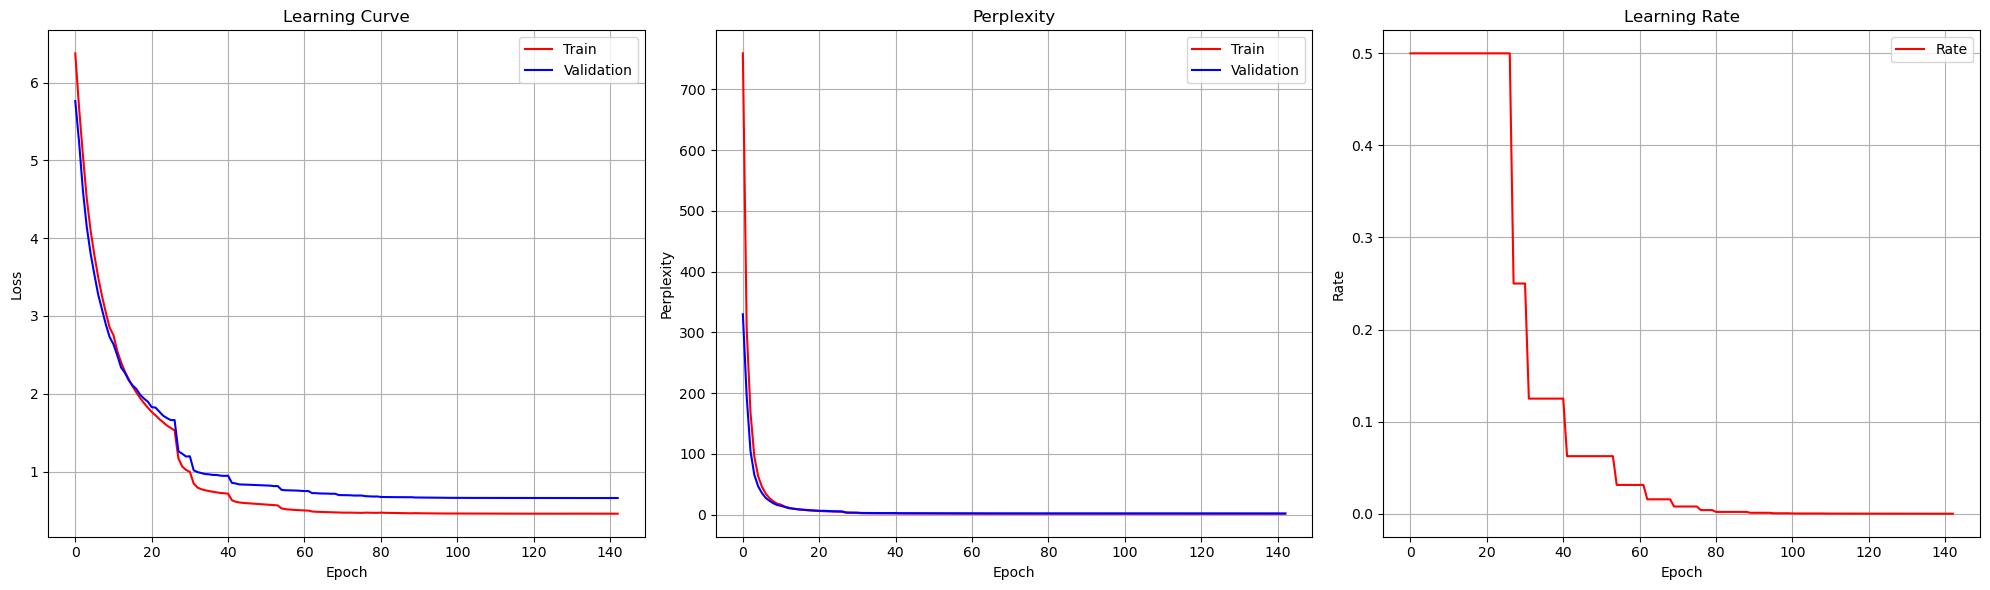

In [21]:
# Save as CSV
import pandas as pd
datas = {
    'epoch': range(epoch_counter),
    'loss_train': loss_train_hist,
    'loss_validation': loss_valid_hist,
    'perplexity_train': per_train_hist , 
    'perplexity_validation':per_valid_hist,
    'learning_rate': lr_train_hist
}
df = pd.DataFrame(datas)
df.to_csv("learningCurve.csv" , index=False)

fig, (ax1, ax2 , ax3) = plt.subplots(1, 3, figsize=(20, 6))

ax1.plot(range(epoch_counter), loss_train_hist, 'r-', label='Train')
ax1.plot(range(epoch_counter), loss_valid_hist, 'b-', label='Validation')
ax1.set_title('Learning Curve')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.grid(True)
ax1.legend()

ax2.plot(range(epoch_counter), per_train_hist, 'r-', label='Train')
ax2.plot(range(epoch_counter), per_valid_hist, 'b-', label='Validation')
ax2.set_title('Perplexity')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Perplexity')
ax2.grid(True)
ax2.legend()

ax3.plot(range(epoch_counter), lr_train_hist, 'r-', label='Rate')
ax3.set_title('Learning Rate')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Rate')
ax3.grid(True)
ax3.legend()

plt.tight_layout()
plt.show()

## Test Perplexity

In [22]:
model_path = 'model.pt'
model = torch.load(model_path)
model = model.to(device)
model.eval()

loss_fn = nn.CrossEntropyLoss()
perp = Perplexity().to(device)

loss_valid , per_valid  = evaluate(model, valid_loader, loss_fn , perp )
print(f"Validation: Loss = {loss_valid:.4} , Perplexity = {per_valid:.4}")

loss_test , per_test  = evaluate(model, test_loader, loss_fn , perp)
print(f"Test: Loss = {loss_test:.4} , Perplexity = {per_test:.4}")

/tmp/ipykernel_16013/1059837893.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(input), torch.tensor(target)


Validation: Loss = 0.6595 , Perplexity = 1.952
Test: Loss = 0.6372 , Perplexity = 1.907


# Text Generation

In [23]:
loss_fn = nn.CrossEntropyLoss()

model_path = 'model.pt'
model = torch.load(model_path)
model = model.to(device)
model.eval()
model

H_LSTM(
  (embedding): Embedding(33278, 500)
  (dropout_em): Dropout(p=0.1, inplace=False)
  (rnn1): LSTM(500, 500, batch_first=True)
  (dropout1): Dropout(p=0.25, inplace=False)
  (rnn2): LSTM(500, 500, batch_first=True)
  (dropout2): Dropout(p=0.25, inplace=False)
  (rnn3): LSTM(500, 500, batch_first=True)
  (dropout3): Dropout(p=0.25, inplace=False)
  (fc): Linear(in_features=500, out_features=33278, bias=True)
)

In [24]:
num_trainable_params(model)

39.323278

In [25]:
def generate(prompt, max_seq_len, temperature, model ):

    global device
    global vocab_itos
    global seq_len
    global char2ind
    
    prompt_tokens = prompt.split(' ')
    prompt_tokens = [char2ind[token] for token in prompt_tokens]  

    with torch.no_grad():
        current_token = torch.tensor(prompt_tokens).unsqueeze(0) 
        current_token = current_token.to(device)
        generated_text = prompt  
        for i in range(max_seq_len):
            output = model(current_token)
            probabilities = nn.functional.softmax(output[:, -1, :] / temperature, dim=-1)
            next_word = "<unk>"
            while next_word == "<unk>":
                next_token_id = torch.multinomial(probabilities, 1).item()
                next_word = findWordByToken(next_token_id)
            
            generated_text += " " + next_word

            next_token_id = torch.tensor([[next_token_id]]).to(device)
            if current_token.shape[1] < seq_len:
                current_token = torch.cat( ( current_token  , next_token_id ), dim=1)
            else:
                current_token = torch.cat( ( current_token[:, 1:]  , next_token_id ), dim=1)
            if next_word in ["<eos>", "."]:
                break
            del next_token_id
    return generated_text

prompt = "i think the movie"
generated_text = generate(prompt, 
                          max_seq_len = 100, 
                          temperature = 0.5, 
                          model = model)

print(generated_text)

i think the movie of his guest events which sets , thereby the between northern move .
